In [1]:
import pandas as pd
import numpy as np

In [2]:
movies = pd.read_csv('ml-latest-small/movies.csv', usecols = ['movieId','title'])
ratings = pd.read_csv('ml-latest-small/ratings.csv', usecols = ['userId', 'movieId', 'rating'])

In [3]:
movies.head()


,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [4]:
ratings.head()


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [5]:
data = pd.merge(ratings, movies, on='movieId')
data.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,1,3,4.0,Grumpier Old Men (1995)
2,1,6,4.0,Heat (1995)
3,1,47,5.0,Seven (a.k.a. Se7en) (1995)
4,1,50,5.0,"Usual Suspects, The (1995)"


In [6]:
movies_ratings = data.dropna(axis = 0, subset = ['title'])
ratings_count = (movies_ratings.
     groupby(by = ['title'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['title', 'totalRatingCount']]
    )
movies_ratings.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,1,3,4.0,Grumpier Old Men (1995)
2,1,6,4.0,Heat (1995)
3,1,47,5.0,Seven (a.k.a. Se7en) (1995)
4,1,50,5.0,"Usual Suspects, The (1995)"


In [7]:
data = movies_ratings.merge(ratings_count, left_on = 'title', right_on = 'title', how = 'left')
data.head()

,userId,movieId,rating,title,totalRatingCount
0,1,1,4.0,Toy Story (1995),215
1,1,3,4.0,Grumpier Old Men (1995),52
2,1,6,4.0,Heat (1995),102
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),203
4,1,50,5.0,"Usual Suspects, The (1995)",204


In [8]:
threshold = 50
data = data.query('totalRatingCount >= @threshold')
data.head()

,userId,movieId,rating,title,totalRatingCount
0,1,1,4.0,Toy Story (1995),215
1,1,3,4.0,Grumpier Old Men (1995),52
2,1,6,4.0,Heat (1995),102
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),203
4,1,50,5.0,"Usual Suspects, The (1995)",204


In [9]:
data.shape

(41362, 5)

In [10]:
# Splitting the data into 90% training and 10% testing
from sklearn.model_selection import train_test_split


train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

# Save the split data into separate files
train_file_path = './ratings_training-90.csv'
test_file_path = './ratings_test-10.csv'

train_data.to_csv(train_file_path, index=False)
test_data.to_csv(test_file_path, index=False)

train_file_path, test_file_path

('./ratings_training-90.csv', './ratings_test-10.csv')

In [11]:
train_data.shape

(37225, 5)

In [12]:
test_data.shape

(4137, 5)

In [13]:
# Create user-item matrix
user_item_matrix = train_data.pivot_table(index='userId', columns='movieId', values='rating')
user_item_matrix.head()

movieId,1,2,3,6,7,10,11,16,17,19,...,91500,91529,96079,99114,106782,109374,109487,112852,116797,122904
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.5,5.0,NaN,3.0,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
from scipy.spatial.distance import euclidean


def unweighted_prediction(user_id, movie_id, k, user_item_matrix):
    if movie_id not in user_item_matrix:
        return 0.0  
    
    target_user = user_item_matrix.loc[user_id].dropna()
    neighbors = []
    
    for neighbor_id in user_item_matrix.index:
        if neighbor_id == user_id or pd.isna(user_item_matrix.loc[neighbor_id, movie_id]):
            continue  # Skip self and users who haven't rated the movie
        
        # Compute Euclidean distance
        common_movies = user_item_matrix.loc[[user_id, neighbor_id]].dropna(axis=1)
        if len(common_movies.columns) == 0:
            continue
        distance = euclidean(common_movies.loc[user_id], common_movies.loc[neighbor_id])
        neighbors.append((neighbor_id, distance))
    
    # Sort neighbors by distance
    neighbors = sorted(neighbors, key=lambda x: x[1])[:k]
    
    # Handle ties for the kth neighbor
    kth_distance = neighbors[-1][1]
    neighbors = [n for n in neighbors if n[1] <= kth_distance]
    
    # Compute the unweighted average
    ratings = [user_item_matrix.loc[n[0], movie_id] for n in neighbors]
    if len(ratings) == 0:
        return 0.0
    return round(np.mean(ratings), 1)


In [15]:
def weighted_prediction(user_id, movie_id, k, user_item_matrix):
    if movie_id not in user_item_matrix:
        return 0.0
    
    target_user = user_item_matrix.loc[user_id].dropna()
    neighbors = []
    
    for neighbor_id in user_item_matrix.index:
        if neighbor_id == user_id or pd.isna(user_item_matrix.loc[neighbor_id, movie_id]):
            continue
        
        common_movies = user_item_matrix.loc[[user_id, neighbor_id]].dropna(axis=1)
        if len(common_movies.columns) == 0:
            continue
        distance = euclidean(common_movies.loc[user_id], common_movies.loc[neighbor_id])
        neighbors.append((neighbor_id, distance))
    
    # Sort neighbors by distance
    neighbors = sorted(neighbors, key=lambda x: x[1])[:k]
    ratings = []
    weights = []
    
    for n in neighbors:
        neighbor_id, distance = n
        if distance == 0:
            weight = 1
        else:
            weight = 1 / distance
        ratings.append(user_item_matrix.loc[neighbor_id, movie_id] * weight)
        weights.append(weight)
    
    if len(ratings) == 0:
        return 0.0
    return round(sum(ratings) / sum(weights), 1)


In [16]:
def generate_predictions(test_data, k, method, user_item_matrix):
    predictions = []
    for _, row in test_data.iterrows():
        user_id, movie_id, real_rating = row['userId'], row['movieId'], row['rating']
        if method == 'unweighted':
            predicted_rating = unweighted_prediction(user_id, movie_id, k, user_item_matrix)
        elif method == 'weighted':
            predicted_rating = weighted_prediction(user_id, movie_id, k, user_item_matrix)
        predictions.append((user_id, movie_id, real_rating, predicted_rating))
    return predictions

In [ ]:
def save_predictions(predictions, method, k):
    """
    Save predictions into a CSV file with the specified naming convention.
    """
    # Define file naming convention
    method_abbreviation = "uw" if method == "unweighted" else "wt"
    filename = f"ratings_predictions_10-knn_{method_abbreviation}_k{k}.csv"
    
    # Save predictions to file
    with open(filename, 'w') as f:
        f.write("userId,movieId,realRating,predictedRating\n")
        for row in predictions:
            f.write(",".join(map(str, row)) + "\n")
    print(f"Saved predictions to {filename}")

# Example: Generate predictions for k = 3, 5, 10
k_values = [3]
methods = ['unweighted', 'weighted']

for k in k_values:
    for method in methods:
        preds = generate_predictions(test_data, k, method, user_item_matrix)
        save_predictions(preds, method, k)

Saved predictions to ratings_predictions_10-knn_uw_k3.csv


In [18]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np

def calculate_rmse(file_path):
    """
    Calculate RMSE from a predictions file.
    """
    # Load the predictions file
    data = pd.read_csv(file_path)
    real_ratings = data['realRating']
    predicted_ratings = data['predictedRating']
    
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(real_ratings, predicted_ratings))
    return rmse

# List of prediction files
prediction_files = [
    "ratings_predictions_10_knn_uw_k3.csv",
    "ratings_predictions_10_knn_wt_k3.csv",
    "ratings_predictions_10_knn_uw_k5.csv",
    "ratings_predictions_10_knn_wt_k5.csv",
    "ratings_predictions_10_knn_uw_k10.csv",
    "ratings_predictions_10_knn_wt_k10.csv"
]

# Calculate and print RMSE for each file
for file in prediction_files:
    rmse_value = calculate_rmse(file)
    print(f"RMSE for {file}: {rmse_value:.4f}")


RMSE for ratings_predictions_10_knn_uw_k3.csv: 1.0157
RMSE for ratings_predictions_10_knn_wt_k3.csv: 1.0286
RMSE for ratings_predictions_10_knn_uw_k5.csv: 0.9617
RMSE for ratings_predictions_10_knn_wt_k5.csv: 0.9755
RMSE for ratings_predictions_10_knn_uw_k10.csv: 0.9328
RMSE for ratings_predictions_10_knn_wt_k10.csv: 0.9404


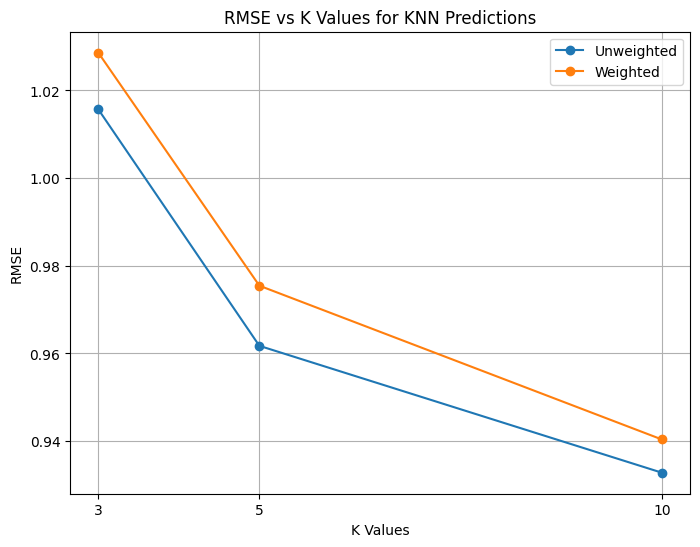

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def calculate_rmse(file_path):
    """
    Calculate RMSE from a predictions file.
    """
    data = pd.read_csv(file_path)
    real_ratings = data['realRating']
    predicted_ratings = data['predictedRating']
    
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(real_ratings, predicted_ratings))
    return rmse

# List of prediction files
prediction_files = {
    "unweighted": ["ratings_predictions_10_knn_uw_k3.csv", 
                   "ratings_predictions_10_knn_uw_k5.csv", 
                   "ratings_predictions_10_knn_uw_k10.csv"],
    "weighted": ["ratings_predictions_10_knn_wt_k3.csv", 
                 "ratings_predictions_10_knn_wt_k5.csv", 
                 "ratings_predictions_10_knn_wt_k10.csv"]
}

# k values for plotting
k_values = [3, 5, 10]
rmse_results = {"unweighted": [], "weighted": []}

# Calculate RMSE for each file
for method, files in prediction_files.items():
    for file in files:
        rmse_value = calculate_rmse(file)
        rmse_results[method].append(rmse_value)

# Plot RMSE values
plt.figure(figsize=(8, 6))
plt.plot(k_values, rmse_results['unweighted'], marker='o', label='Unweighted')
plt.plot(k_values, rmse_results['weighted'], marker='o', label='Weighted')

# Labeling the plot
plt.title('RMSE vs K Values for KNN Predictions')
plt.xlabel('K Values')
plt.ylabel('RMSE')
plt.xticks(k_values)
plt.legend()
plt.grid()
plt.show()
